In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
from IPython.display import Image, display
from dask.distributed import Client, progress
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import matplotlib.patheffects as PathEffects
import scipy
from scipy.ndimage import gaussian_filter
import numpy.ma as ma
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import ImageGrid
import metpy.calc as mpcalc
from metpy.units import units
import matplotlib.colors as mcolors
%matplotlib inline

#### Import CFSv2

In [2]:
def preprocess(ds):
    '''keep only the selected lats and lons'''
    return ds.sel(latitude=slice(10,50), longitude=slice(210,250))

filename_pattern =  '/home/sbarc/students/nash/data/CFSv2/netcdf_CFSv2_vertical_levels/201*'
ds = xr.open_mfdataset(filename_pattern, engine='netcdf4', preprocess=preprocess)
## select only 9 timesteps of data
ds = ds.sel(time=slice('2019-03-04-18', '2019-03-06-18'))
### Variables needed for IVT ###
da_SPFH = ds.spfh.sel(p=slice(1000,300))
da_V = ds.v.sel(p=slice(1000,300))
da_U = ds.u.sel(p=slice(1000,300))
pressure = ds.p.sel(p=slice(1000,300)).values
ivt_lat = ds.latitude
ivt_lon = ds.longitude

### Calculate IVT ###
g = -9.81 # gravity constant
ivt_u = scipy.integrate.trapz(da_U*da_SPFH, pressure, axis=1)*g
print(ivt_u.shape)
ivt_v = scipy.integrate.trapz(da_V*da_SPFH, pressure, axis=1)*g
print(ivt_v.shape)
ivt_total = np.sqrt(ivt_u**2 + ivt_v**2)

### Variables needed for EPT ###
plev = 850.0
T = ds.temp.sel(p=plev) - 273.15 ## convert to degrees Celsius
RH = ds.rh.sel(p=plev)
da_U_850 = ds.u.sel(p=plev) * 1.94384 ## convert to knots
da_V_850 = ds.v.sel(p=plev) * 1.94384 ## convert to knots


(9, 81, 81)
(9, 81, 81)


In [3]:
## Calculate the dewpoint from relative humidity and temperature
td = 243.5*(np.log(RH/100)+((17.67*T)/(243.5+T)))/(17.67-np.log(RH/100)-((17.67*T)/(243.5+T)))
td = td.values +273.15 * units.degK
T = T.values +273.15 * units.degK ## convert back to kelvin?

pres = np.tile(plev, T.shape)
pres = pres * units.hPa
td.shape

/home/sbarc/students/nash/anaconda3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log
  return func(*args2)
/home/sbarc/students/nash/anaconda3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


(9, 81, 81)

In [4]:
## Calculate Equivalent Potential Temperature
ept = mpcalc.equivalent_potential_temperature(pressure=pres, temperature=T, dewpoint=td)
ept.shape

(9, 81, 81)

## Plot

./figures/fS5.png


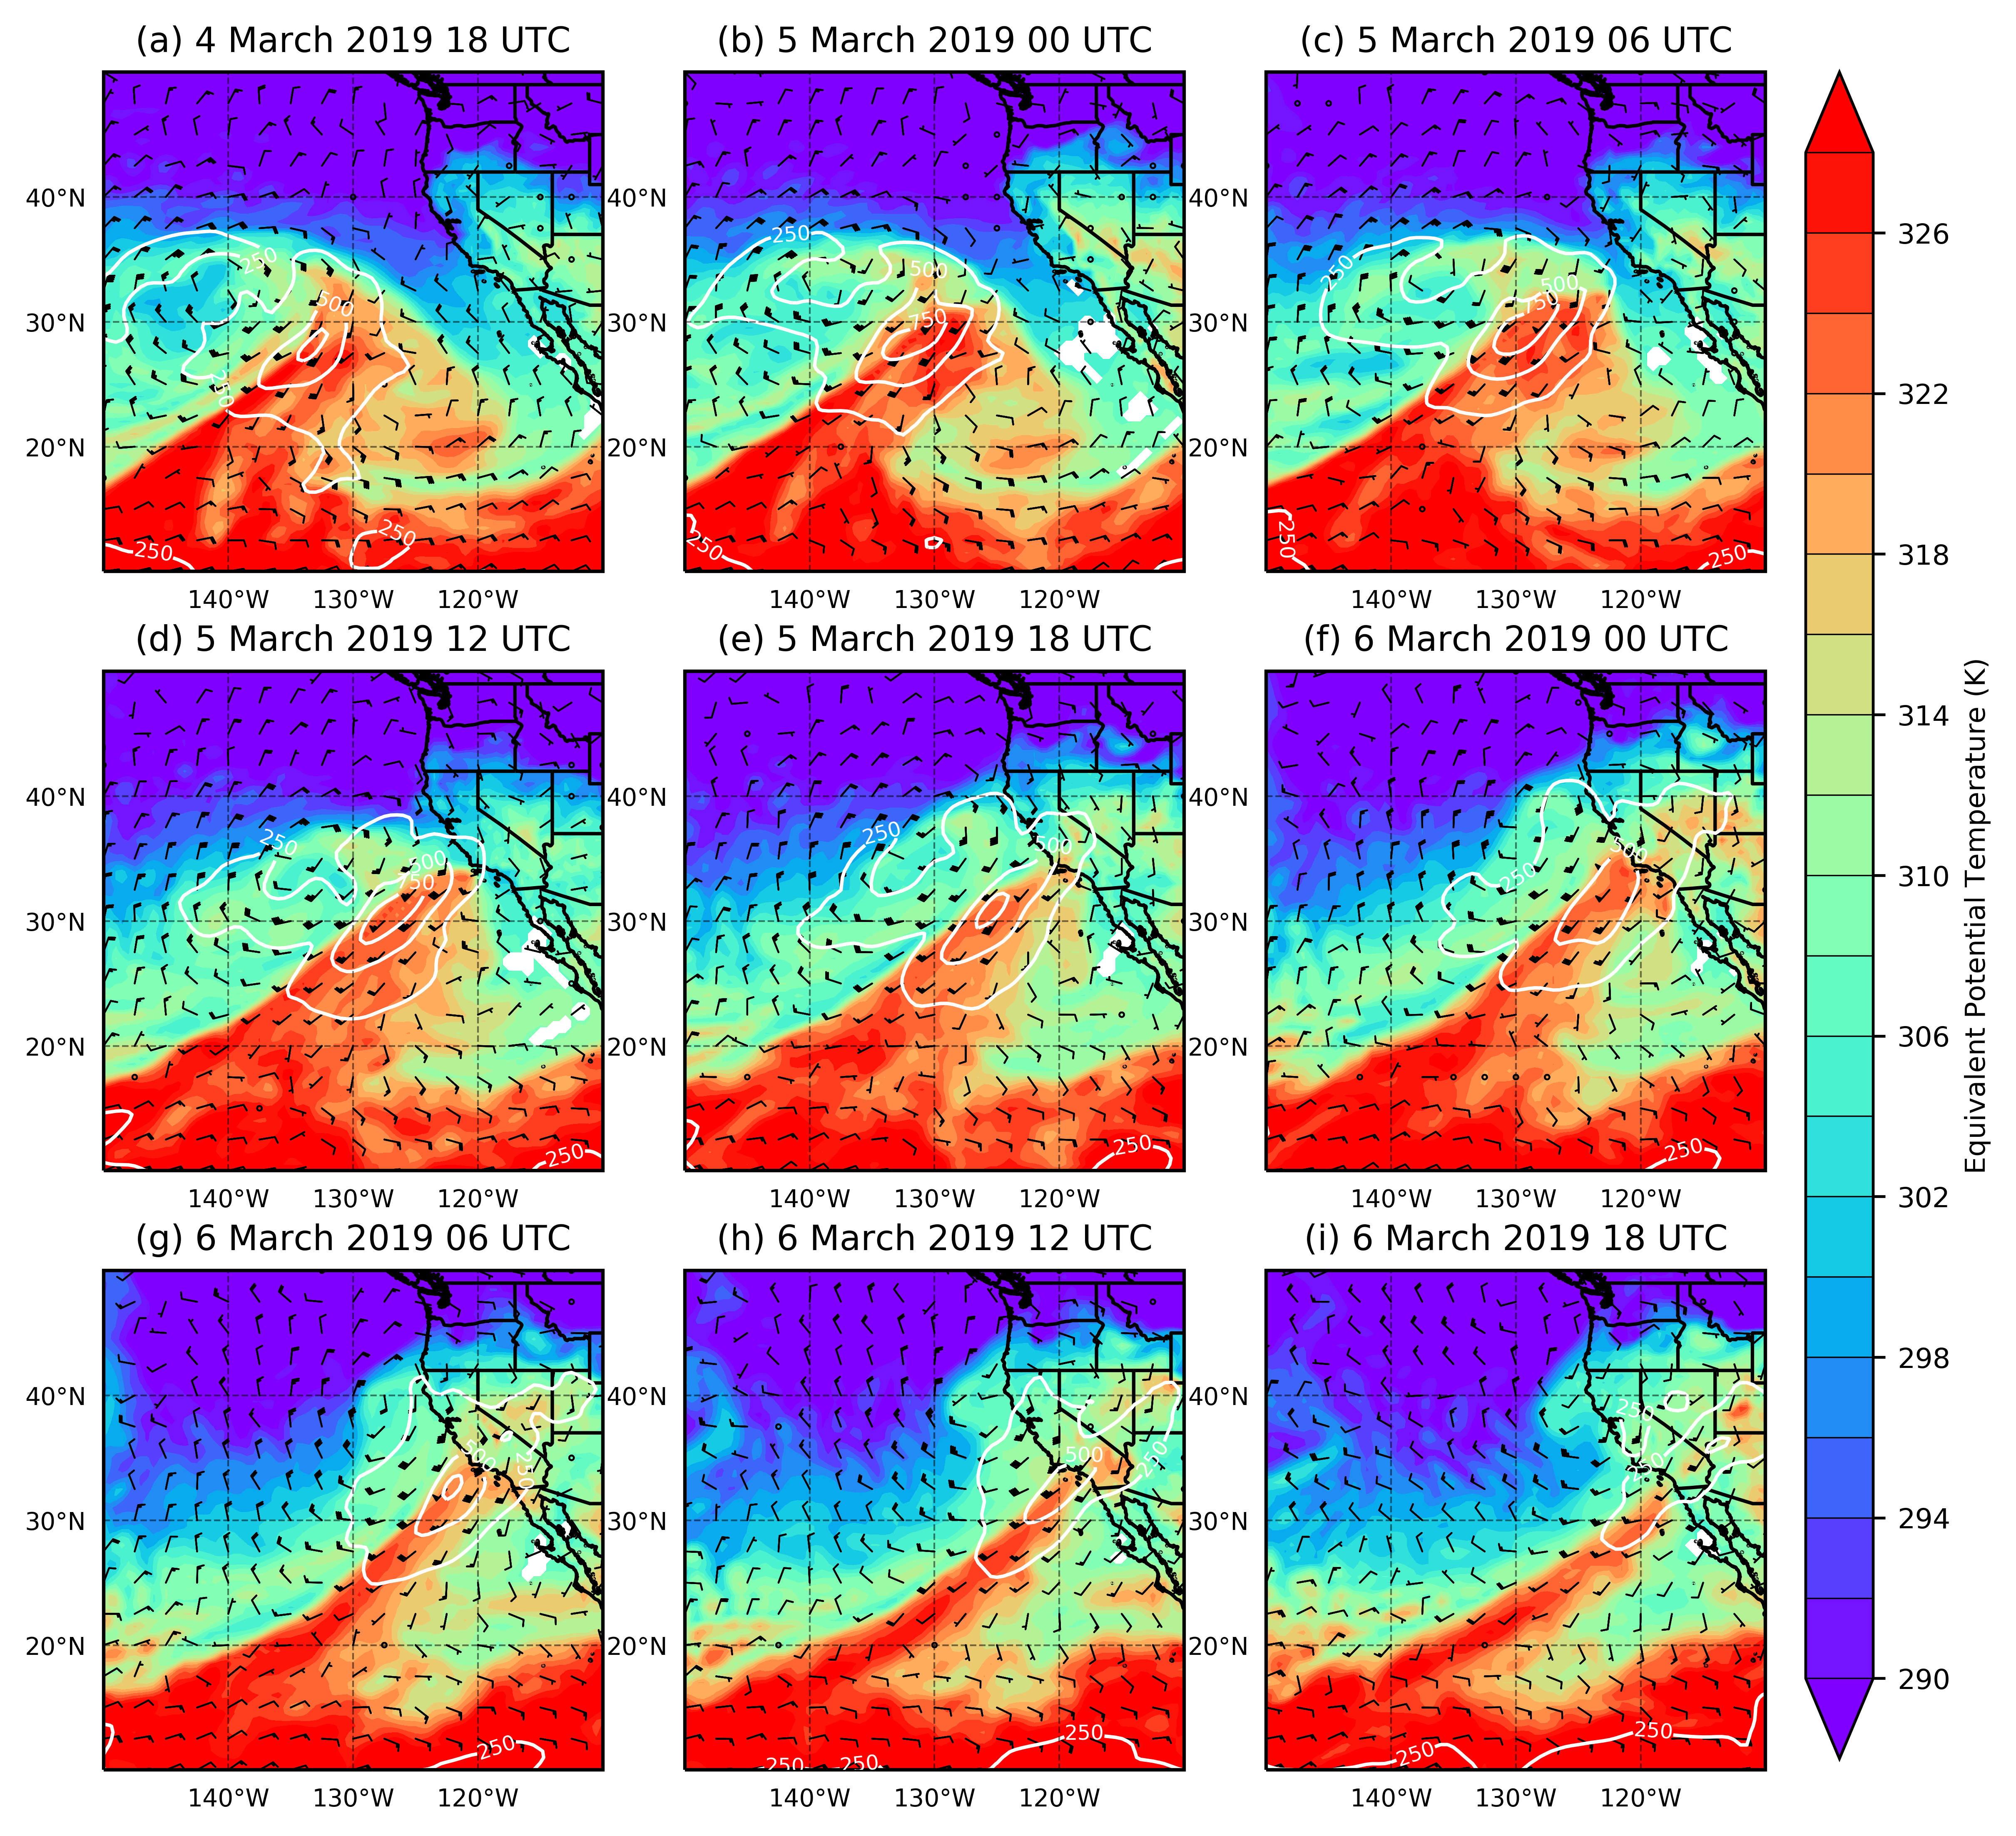

<Figure size 5400x5400 with 0 Axes>

In [5]:
fig = plt.figure(figsize=(9,9))
fig.dpi = 600
fname = './figures/fS5'
fmt1 = 'png'
fmt2 = 'pdf'
results = ept
ext = [250.-360.0, 210.-360., 10., 50.0] ## zoomed out synoptic scale

# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

subtitles = ['(a) 4 March 2019 18 UTC', 
             '(b) 5 March 2019 00 UTC', '(c) 5 March 2019 06 UTC', '(d) 5 March 2019 12 UTC',
             '(e) 5 March 2019 18 UTC',
            '(f) 6 March 2019 00 UTC', '(g) 6 March 2019 06 UTC', '(h) 6 March 2019 12 UTC',
             '(i) 6 March 2019 18 UTC']

lats = ds['latitude']
lons = ds['longitude']
clevsept = np.arange(290, 330, 2)

for i in np.arange(len(results)):
    ax = plt.subplot(3, 3, i+1, projection=mapcrs)
    ax.set_extent(ext, crs=mapcrs)
    cf = ax.contourf(lons, lats, results[i,:,:], transform=datacrs, cmap='rainbow'
                     ,levels=clevsept, extend='both')
    # Plot winds
    barbx = 5
    barbs = ax.barbs(lons[::barbx], lats[::barbx],
                     da_U_850[i, ::barbx, ::barbx], da_V_850[i, ::barbx, ::barbx],
                     length=3, linewidth=0.5)
    
#     # Plot EPT contours
#     kw_clabels = {'fontsize': 6, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
#                   'rightside_up': True, 'use_clabeltext': True}
#     cs = ax.contour(lons, lats, ept[i,:,:], levels=clevsept, colors='white',
#                     linewidths=0.75, linestyles='solid', transform=datacrs)
#     plt.clabel(cs, **kw_clabels)

    # Plot IVT contours
    ivtclevs = np.arange(250,1250,250)
    ivt_sm = gaussian_filter(ivt_total[i], sigma=1.0)
    cs = ax.contour(ivt_lon, ivt_lat, ivt_sm, ivtclevs, colors='white', linewidths=1.0,
                      linestyles='solid', transform=datacrs)
    kw_clabels = {'fontsize': 6, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
                  'rightside_up': True, 'use_clabeltext': True}
    plt.clabel(cs, **kw_clabels)
    
    # Add Border Features
    ax.coastlines(linewidths=1.0, resolution='10m')
    ax.add_feature(states_provinces, edgecolor='k')
    ax.add_feature(cfeature.BORDERS)
    
    ax.set_title(subtitles[i], fontsize=10)
    ## Add in meridian and parallels
    gl = ax.gridlines(crs=mapcrs, draw_labels=True,
                  linewidth=.5, color='black', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator([-150, -140, -130, -120, -110])
    gl.ylocator = mticker.FixedLocator([10,20, 30, 40, 50])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 7}
    gl.ylabel_style = {'size': 7}

# # add colorbar [left, bottom, width, height]
ax2 = fig.add_axes([0.9, 0.13, 0.03, 0.75])
cbar = fig.colorbar(cf, cax=ax2, drawedges=True, 
                    orientation='vertical', extendfrac='auto', extend='max')
cbar.ax.tick_params(labelsize=8)
cbar.set_label('Equivalent Potential Temperature (K)', fontsize=8)

plt.subplots_adjust(hspace=0.2, wspace=0.003)

fig.savefig('%s.%s' %(fname, fmt1), bbox_inches='tight', dpi=fig.dpi)
fig.savefig('%s.%s' %(fname, fmt2), bbox_inches='tight', dpi=fig.dpi)
fig.clf()


plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))